In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


In [2]:
import pandas as pd

# Time Series Analysis

[source](https://www.sigmacomputing.com/resources/learn/what-is-time-series-analysis),
[source](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)

At its core, time series analysis focuses on studying and interpreting a sequence of **data points collected at consistent time intervals**.
Time series data is fundamentally dynamic, evolving over chronological sequences both short and extremely long.
This type of analysis is pivotal in uncovering underlying structures within the data, such as **trends**, **cycles**, and **seasonal variations**.

We can identify three main areas:

1. **Time series data** refers to the raw sequence of observations indexed in time order.

1. **Time series analysis**, the practice of systematically studying this data to identify and model its internal structures such seasonality, trends, and cycles.

1. **Time series forecasting** which uses historical data to make future projections, often employing statistical models like ARIMA  or machine learning models like gradient boosting regressors or deep recurrent neural networks (e.g. LSTM).

Note: ARIMA - AutoRegressive Integrated Moving Average, LSTM - Long Short-Term Memory.

# Time Series Data

Time series data are time indexed observations.  As an example we will use the [air passengers data set](https://www.kaggle.com/datasets/chirag19/air-passengers) which provides monthly totals of a US airline passengers from 1949 to 1960.

In [3]:
# air passenger data
air_df = pd.read_csv(home+'AirPassengers.csv')
air_df.columns = ['Date','Number of Passengers'] # rename columns for convenience
air_df.index = pd.DatetimeIndex(air_df['Date']) # create a time index
air_df.drop(columns=['Date'], inplace=True)
air_df.head()

,Number of Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Of course the best way to see the data is to visualize/plot it.

<Axes: xlabel='Date'>

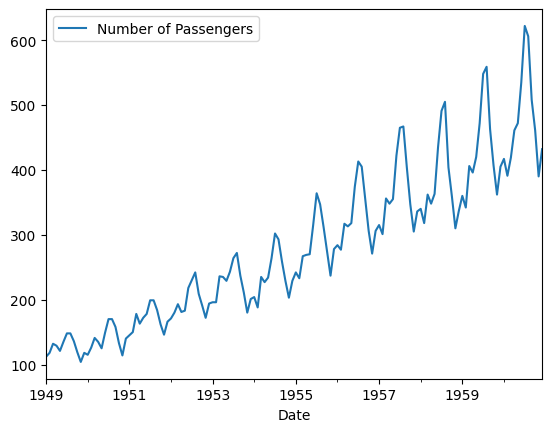

In [4]:
air_df.plot()

It is clear from the plot that there is some structure to the time series data.  We can clearly identify a **trend** and **seasonality**.




## Components of Time Series Data


**Trends** show the general direction of the data, and whether it is increasing, decreasing, or remaining stationary over an extended period of time. Trends indicate the long-term movement in the data and can reveal overall growth or decline. For example, e-commerce sales may show an upward trend over the last five years.

**Seasonality** refers to predictable patterns that recur regularly, like yearly retail spikes during the holiday season. Seasonal components exhibit fluctuations fixed in timing, direction, and magnitude. For instance, electricity usage may surge every summer as people turn on their air conditioners.

**Cycles** demonstrate fluctuations that do not necessarily have a fixed period, such as economic expansions and recessions. These longer-term patterns last longer than a year and do not have consistent amplitudes or durations. Business cycles that oscillate between growth and decline are an example.

**Noise** encompasses the residual variability in the data that the other components cannot explain. Noise includes unpredictable, erratic deviations after accounting for trends, seasonality, and cycles.



# Trend Analysis

Trends are long-term increases, decreases, or stationary movements.

Before we can embark on the trend analysis in our data we need to create a data frame indexed by time, i.e. the rows of our dataframe are named by time objects.

## Rolling Windows

Rolling windows (or sliding windows) are perhaps the easiest way to visualize trends.  The idea is to define a **time window** of the suitable length and use the data points within that window to compute the desired statistic. Once this has been accomplished you move window one data point "to the right."

Let's try this with out data.  Given that we have monthly data a good window size is probably 12 months.

In [5]:
window_size = 12

Note, the window size is specified in data points.  If we had daily observation then our window size for a year would have to be 365.

We can now apply the `rolling` function to our time index dataframe in order to compute our statistic.  The statistic we chose here is `mean`, that is, we will compute the **average number of passengers within the window**.  This will act like a smoothing function and will remove all seasonal variations.

In [6]:
air_window_df = air_df.rolling(window_size, min_periods=1).mean()
air_window_df.head()


,Number of Passengers
Date,
1949-01-01,112.000000
1949-02-01,115.000000
1949-03-01,120.666667
1949-04-01,122.750000
1949-05-01,122.400000


<Axes: xlabel='Date'>

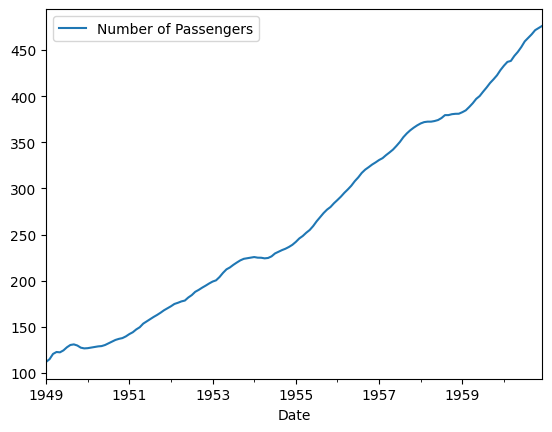

In [7]:
air_window_df.plot()

**Observation**: We obtain an almost linear trend curve.  Interesting to note are the bumps at 1950, 1954, and 1958.  Are those external influences occuring every 4 years?  Presidential elections?  Note that these trend abnormalities were not visible in the original data.  The might be examples of **cycles**.

We can plot the original passenger data and the rolling window data together in one plot.

<Axes: xlabel='Date'>

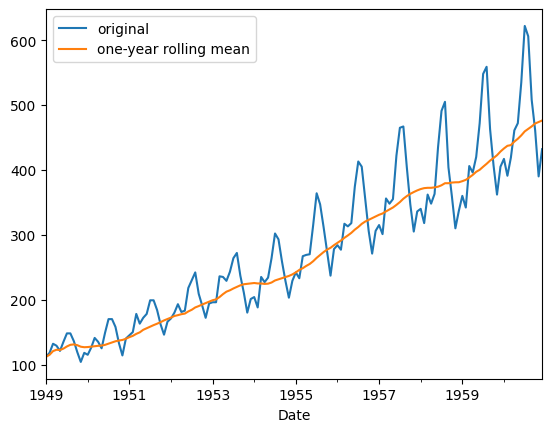

In [8]:
data = pd.DataFrame({'original': air_df['Number of Passengers'],
                     'one-year rolling mean': air_window_df['Number of Passengers']})
data.plot()

### The Effect of Window Size

The selection of the rolling window size can have a drastic effect on the quality of the trend plot.  Consider for a moment that we have picked a window size too small, say 6 months.

<Axes: xlabel='Date'>

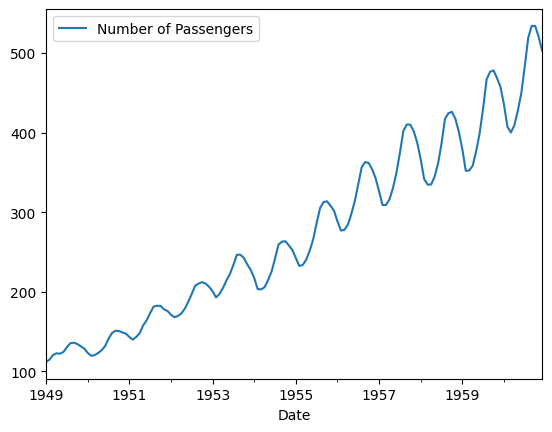

In [9]:
air_df.rolling(6, min_periods=1).mean().plot()

Because air travel follows a 12 months seasonality cycle picking a 6 months window allows some of seasonality to show through.

To see what happens if we pick the window too large we pick a window of 36 months.

<Axes: xlabel='Date'>

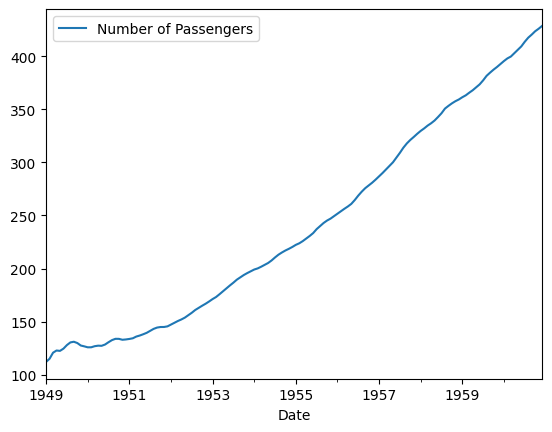

In [10]:
air_df.rolling(36, min_periods=1).mean().plot()

Nothing too drastic happens, but some of the finer details of the trend curve are lost.

## Aggregation/Resampling

Another approach to trend analysis is aggregation or resampling by specific time frames.  It is similar to the rolling window except that we specify the windows we want to aggregate over.

In our case, if we aggregate on a per month basis we get our original data back.

<Axes: xlabel='Date'>

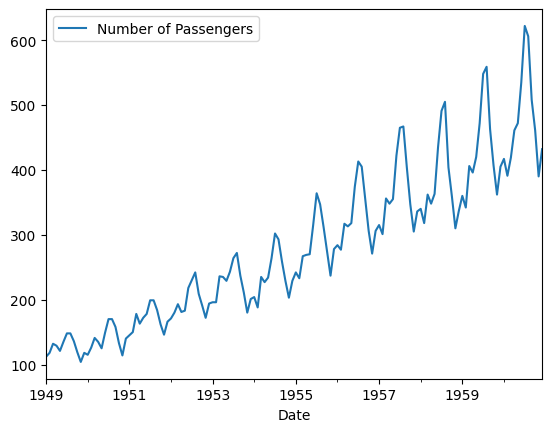

In [11]:
air_df.resample('M').mean().plot() # 'M' means month

If we aggregate on a yearly basis we obtain,

In [12]:
air_resample_df = air_df.resample('Y').mean()
air_resample_df

,Number of Passengers
Date,
1949-12-31,126.666667
1950-12-31,139.666667
1951-12-31,170.166667
1952-12-31,197.000000
1953-12-31,225.000000
1954-12-31,238.916667
1955-12-31,284.000000
1956-12-31,328.250000
1957-12-31,368.416667


<Axes: xlabel='Date'>

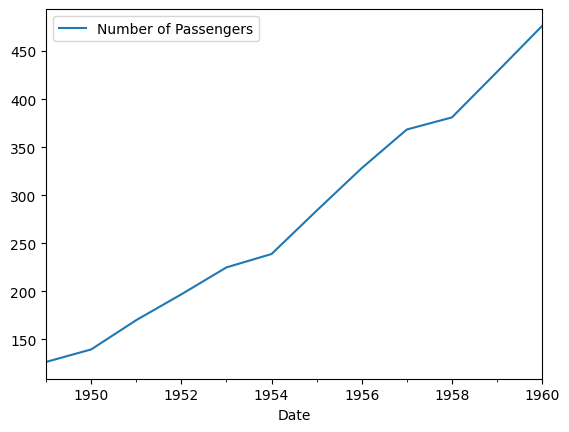

In [13]:
air_resample_df.plot()

Because we are only looking at 11 windows instead of many rolling windows the resulting plot is much smoother.  But we can still identify the interesting cyclic halmarks.

# Seasonality Analysis

Seasonality analysis hinges on figuring out what kind of time series we are dealing with,

1. **Additive**:  In an additive time series, the components add together to make the time series. This means that if there is an increasing trend, the **peaks and troughs will remain roughly the same size** throughout the time series.  It follows the following additive decomposition,

    y(t) = trend(t) + season(t) + noise(t)

  where t ranges over the time index of the series.

1. **Multiplicative**: In a multiplicative time series, the components multiply together to make the time series. If you have an increasing trend, the amplitude of seasonal activity increases. Everything becomes more exaggerated.
It follows the following multiplicative decomposition,

    y(t) = trend(t) * season(t) * noise(t)

  where t ranges over the time index of the series.


Let's assume that our time series is additive and does not have any noise then we can compute the seasonal component as,

season(t) = y(t) - trend(t)

<Axes: xlabel='Date'>

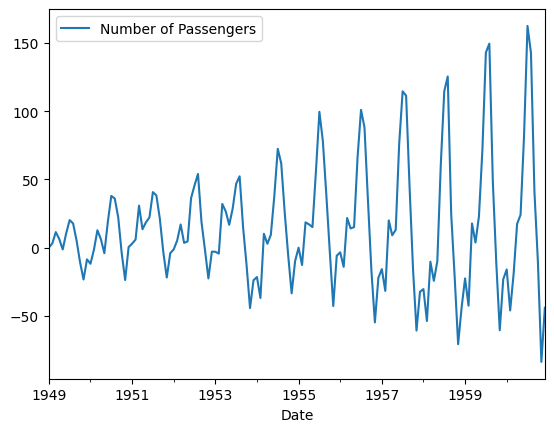

In [14]:
air_season_df = air_df - air_window_df
air_season_df.plot()

That does not look good, we still have some trend information in the seasonal values.  That means most likely we are dealing with a multiplicative time series.  Using the formula for a multiplicative time series and again assuming no noise we can compute the seasonal component as

season(t) = y(t)/trend(t)

Let's try this,

<Axes: xlabel='Date'>

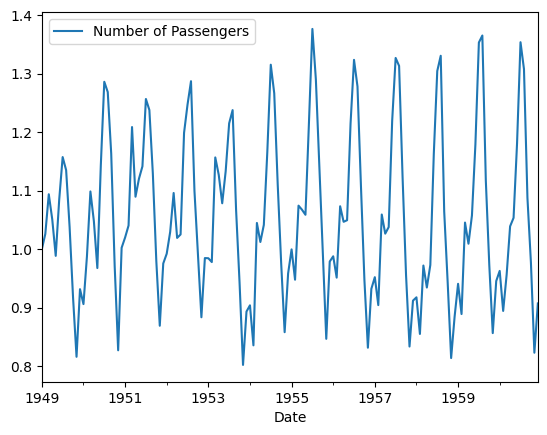

In [15]:
air_season_df = air_df / air_window_df
air_season_df.plot()

That looks pretty good, we can clearly see the periods of the activity cycle for the airlines and no trend information is visible.

# There is a Module for that

The Python `statsmodels` module has a function that allows use to do this kind of seasonal analysis.

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

As before, let's try the additive analysis first.

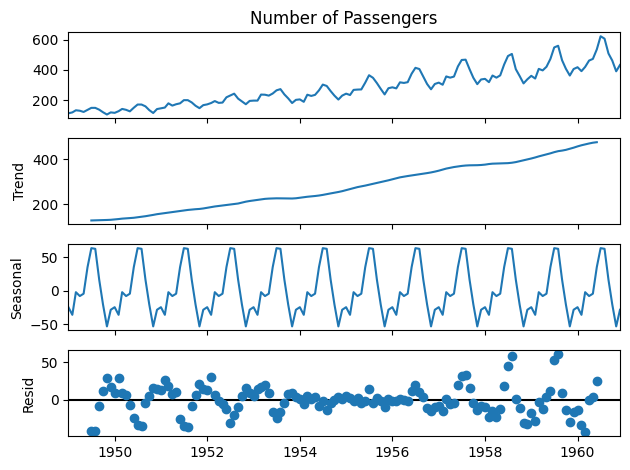

In [17]:
decomp = seasonal_decompose(air_df['Number of Passengers'], model='additive')
null = decomp.plot()

**Observation**: The fact that we can observe a relatively strong signal in the residuals means that the additive model is not the correct one.

Let's try the multiplicative model.

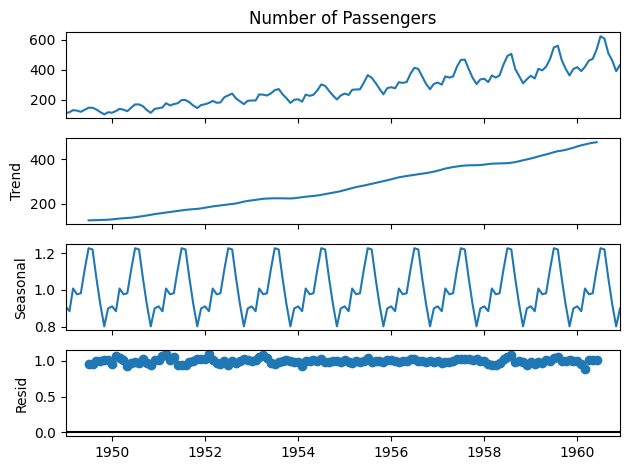

In [18]:
decomp = seasonal_decompose(air_df['Number of Passengers'], model='multiplicative')
null = decomp.plot()

**Observation**: Almost no signal in the residuals, seems to be some constant bias is being subtracted out of the passenger data.

We can access the individual plots.

<Axes: xlabel='Date'>

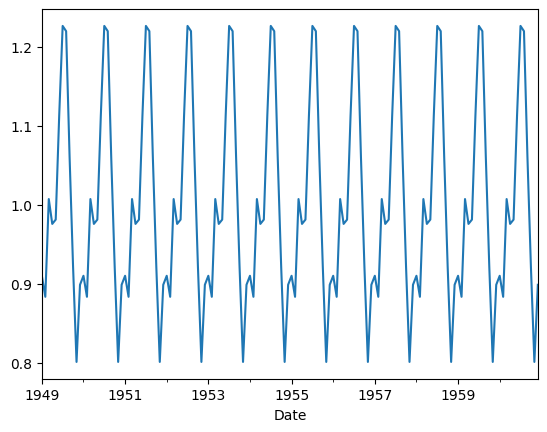

In [19]:
decomp.seasonal.plot()

<Axes: xlabel='Date'>

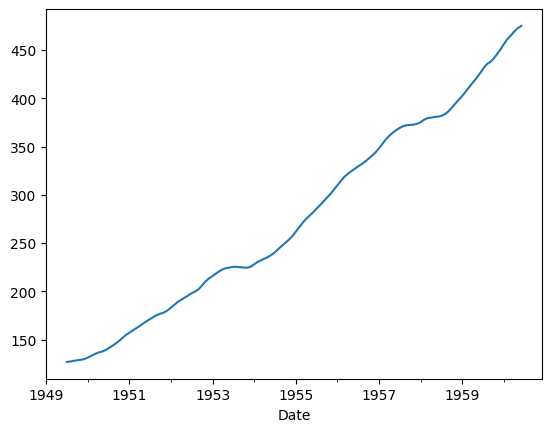

In [20]:
decomp.trend.plot()